<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install git+https://github.com/yeoun9/torchpm.git
! pip install sympytorch

  Cloning https://github.com/yeoun9/torchpm.git to c:\users\sungwoo\appdata\local\temp\pip-req-build-jas644sp
  Resolved https://github.com/yeoun9/torchpm.git to commit 1b73f2035598bb05db1b70c99e5ab462ad1cfc05
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for torchpm: filename=torchpm-0.0.3-py3-none-any.whl size=18296 sha256=1909340887ce3ccd45845a7d8b5f0ebe10fcc0f413572b15047e5a4adda5efbb
  Stored in directory: C:\Users\sungwoo\AppData\Local\Temp\pip-ephem-wheel-cache-xl77rw7o\wheels\dc\72\dd\d30f04632dad3b07fc5fd9017cf6af44bedce51258901ca564
Successfully built torchpm


  Running command git clone --filter=blob:none --quiet https://github.com/yeoun9/torchpm.git 'C:\Users\sungwoo\AppData\Local\Temp\pip-req-build-jas644sp'


In [2]:
from torchpm import *
from torchpm.data import CSVDataset
from torchpm.estimated_parameter import *
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

# Model Building

In [3]:
class BasementModel(predfunction.PredictionFunctionByTime) :
    '''
        pass
    '''
    def _set_estimated_parameters(self):
        self.theta_0 = Theta(0., 1.5, 10.)
        self.theta_1 = Theta(0., 30., 100.)
        self.theta_2 = Theta(0, 0.08, 1)

        self.eta_0 = Eta()
        self.eta_1 = Eta()
        self.eta_2 = Eta()

        self.eps_0 = Eps()
        self.eps_1 = Eps()

        self.gut_model = linearode.Comp1GutModelFunction()
    
    def _calculate_parameters(self, covariates):
        covariates['k_a'] = self.theta_0()*tc.exp(self.eta_0())
        covariates['v'] = self.theta_1()*tc.exp(self.eta_1())#*para['BWT']/70
        covariates['k_e'] = self.theta_2()*tc.exp(self.eta_2())
        covariates['AMT'] = tc.tensor(320., device=self.dataset.device)

    def _calculate_preds(self, t, p):
        dose = p['AMT'][0]
        k_a = p['k_a']
        v = p['v']
        k_e = p['k_e']
        comps = self.gut_model(t, k_a, k_e, dose)
        return comps[1]/v
        
    def _calculate_error(self, y_pred, p):
        p['v_v'] = p['v'] 
        return y_pred +  y_pred * self.eps_0() + self.eps_1()

dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO.csv'
# dataset_file_path = './examples/THEO.csv'
dataset_np = np.loadtxt(dataset_file_path, delimiter=',', dtype=np.float32, skiprows=1)



device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
column_names = ['ID', 'AMT', 'TIME', 'DV', 'CMT', "MDV", "RATE", 'BWT']
dataset = CSVDataset(dataset_np, column_names, device)

pred_function_module = BasementModel(dataset = dataset,
                            output_column_names=['ID', 'TIME', 'AMT', 'k_a', 'v', 'k_e'])

omega = Omega([0.4397,
                0.0575,  0.0198, 
                -0.0069,  0.0116,  0.0205], False, requires_grads=False)
sigma = Sigma([[0.0177], [0.0762]], [True, True], requires_grads=[False, True])

model = models.FOCEInter(pred_function_module, 
                        theta_names=['theta_0', 'theta_1', 'theta_2'],
                        eta_names= ['eta_0', 'eta_1','eta_2'], 
                        eps_names= ['eps_0','eps_1'], 
                        omega=omega, 
                        sigma=sigma)
                        
model = model.to(device)
model.fit_population(learning_rate = 1, tolerance_grad = 1e-5, tolerance_change= 1e-3)
#TODO 주의사항 다운로드 할때 캐쉬 파일이 있으면 업데이트가 되지 않아서 이상하게 계산되는 경우가 있으니 주의해야함.



running_time :  2.085925579071045 	 total_loss: tensor(490.1509, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  2.915858507156372 	 total_loss: tensor(403.7401, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  3.7347378730773926 	 total_loss: tensor(343.5059, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  4.5679402351379395 	 total_loss: tensor(267.9600, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  5.386206150054932 	 total_loss: tensor(243.7507, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  6.34065318107605 	 total_loss: tensor(202.4627, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  7.454614877700806 	 total_loss: tensor(168.2006, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  8.635112047195435 	 total_loss: tensor(137.0659, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  9.780082941055298 	 total_loss: tensor(131.7247, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  10.921172142028809 	 total_lo

FOCEInter(
  (pred_function_module): BasementModel(
    (theta_0): Theta()
    (theta_1): Theta()
    (theta_2): Theta()
    (eta_0): Eta(
      (parameter_values): ParameterDict(
          (1): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (2): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (3): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (4): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (5): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (6): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (7): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (8): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (9): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (10): Parameter containing: [torch.cuda.FloatTensor of size  (GPU 0)]
          (11): Parameter con

# Result

time-pred


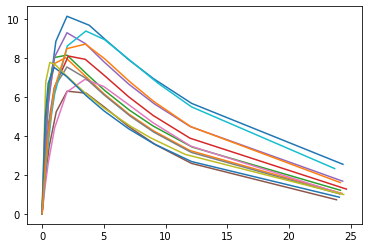

time-cwres


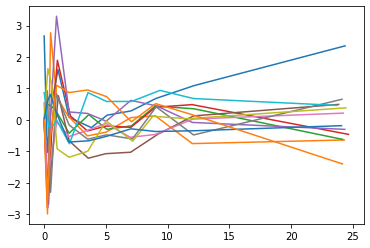

In [4]:
eval_result = model.descale().evaluate()

print('time-pred')
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
for id, v in eval_result.items() :
    time = v['time'].to('cpu')
    y_pred = v['pred'].detach().to('cpu').numpy()
    cwres_value = v['cwres']
    ax1.plot(time, y_pred)
    ax2.plot(time, cwres_value)
plt.show()

In [5]:
for k, v in eval_result.items():
    print(k)
    print(v)

total_loss
tensor(92.2372, device='cuda:0')
losses
{'1': 20.1060733795166, '2': 17.388586044311523, '3': -1.239400863647461, '4': 9.331997871398926, '5': 20.181438446044922, '6': 4.102354049682617, '7': 1.3771934509277344, '8': 3.9288082122802734, '9': 3.0365686416625977, '10': 4.687624931335449, '11': -2.537403106689453, '12': 11.87339973449707}
times
{'1': tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700], device='cuda:0'), '2': tensor([ 0.0000,  0.0000,  0.2700,  0.5200,  1.0000,  1.9200,  3.5000,  5.0200,
         7.0300,  9.0000, 12.0000, 24.3000], device='cuda:0'), '3': tensor([ 0.0000,  0.0000,  0.2700,  0.5800,  1.0200,  2.0200,  3.6200,  5.0800,
         7.0700,  9.0000, 12.1500, 24.1700], device='cuda:0'), '4': tensor([ 0.0000,  0.0000,  0.3500,  0.6000,  1.0700,  2.1300,  3.5000,  5.0200,
         7.0200,  9.0200, 11.9800, 24.6500], device='cuda:0'), '5': tensor([ 0.0000,  0.0000,  0.3000,  0.5200,  1.

In [6]:
cov_result = model.descale().covariance_step()
print(cov_result)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
{'cov': tensor([[ 3.7769e-03,  2.8518e-02, -1.6362e-04,  1.6422e-03,  2.4337e-04,
          1.2351e-04,  1.8062e-04,  2.0626e-04,  3.4963e-04, -3.8636e-04,
          3.2026e-03],
        [ 2.8529e-02,  3.5381e-01, -1.5117e-03,  7.7771e-03, -2.0221e-03,
          3.1307e-04, -1.9941e-03,  1.2728e-03,  2.2517e-03, -1.1230e-03,
          9.2130e-03],
        [-1.6368e-04, -1.5117e-03,  7.8156e-06, -4.6408e-05, -1.4319e-06,
         -4.3045e-06, -1.9048e-06, -8.8919e-06, -1.4713e-05,  1.4132e-05,
         -1.1067e-04],
        [ 1.6478e-03,  7.8067e-03, -4.6672e-05,  2.7721e-02,  3.6137e-03,
          2.7598e-04,  5.1467e-04, -1.2038e-04, -3.5817e-04, -2.2059e-04,
         -2.3343e-03],
        [ 2.4474e-04, -2.0140e-03, -1.4988e-06,  3.6186e-03,  6.9239e-04,
          7.6434e-05,  3.2545e-04,  9.2209e-06, -3.8071e-05, -5.8245e-05,
         -5.1844e-05],
        [ 1.2362e-04,  3.1378e-04, -4.3137e-06,  2.7642e-04,  7.6360e-05,


In [7]:
for (name, para) in model.named_parameters():
    print(name)
    print(para.detach().clone().to('cpu').numpy())

pred_function_module.theta_0.parameter_value
1.4884187
pred_function_module.theta_1.parameter_value
32.53308
pred_function_module.theta_2.parameter_value
0.087218754
pred_function_module.eta_0.parameter_values.1
-0.10249746
pred_function_module.eta_0.parameter_values.2
0.34311932
pred_function_module.eta_0.parameter_values.3
0.42356002
pred_function_module.eta_0.parameter_values.4
-0.33202454
pred_function_module.eta_0.parameter_values.5
-0.023071432
pred_function_module.eta_0.parameter_values.6
-0.45523816
pred_function_module.eta_0.parameter_values.7
-0.8398764
pred_function_module.eta_0.parameter_values.8
-0.052083578
pred_function_module.eta_0.parameter_values.9
1.3832785
pred_function_module.eta_0.parameter_values.10
-0.6992781
pred_function_module.eta_0.parameter_values.11
0.8787484
pred_function_module.eta_0.parameter_values.12
-0.48869225
pred_function_module.eta_1.parameter_values.1
-0.18984173
pred_function_module.eta_1.parameter_values.2
0.05330867
pred_function_module.eta_1

#Simulation

id 1


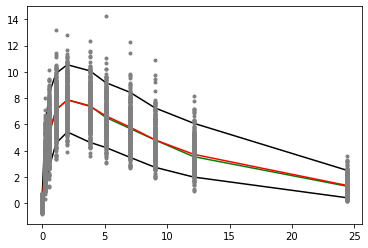

id 2


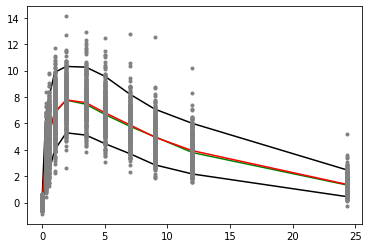

id 3


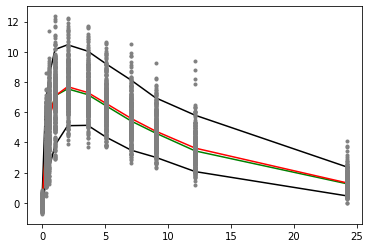

id 4


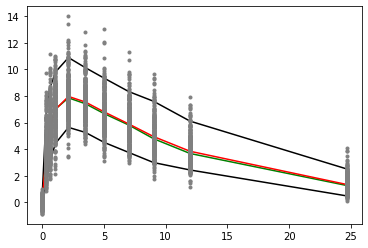

id 5


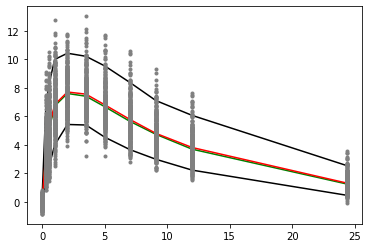

id 6


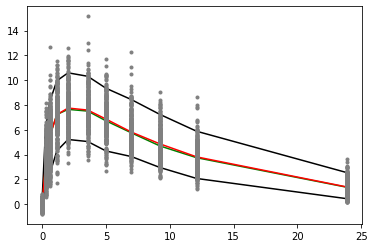

id 7


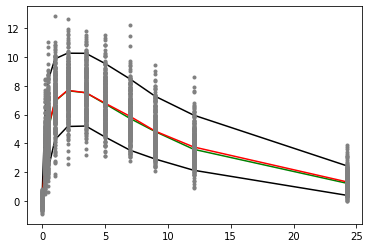

id 8


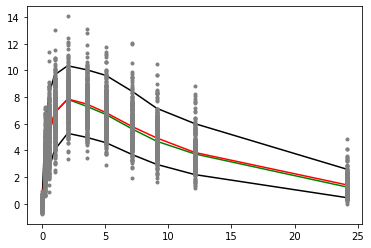

id 9


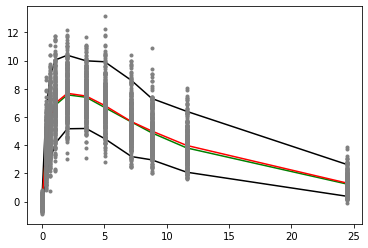

id 10


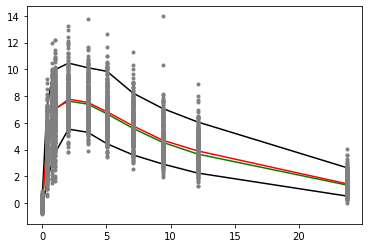

id 11


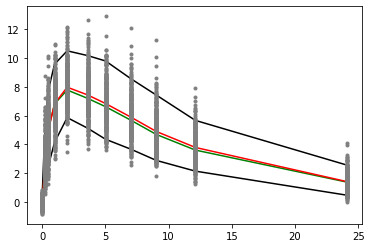

id 12


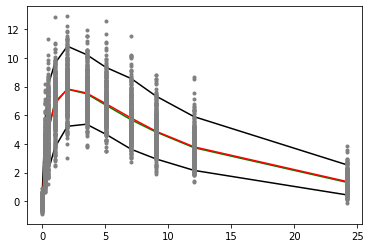

In [10]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

for id, values in simulation_result.items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    time_data : tc.Tensor = values['time'].to('cpu')
    
    preds : List[tc.Tensor] = values['preds']
    preds_tensor = tc.stack(preds).to('cpu')
    p95 = np.percentile(preds_tensor, 95, 0)
    p50 = np.percentile(preds_tensor, 50, 0)
    average = np.average(preds_tensor, 0)
    p5 = np.percentile(preds_tensor, 5, 0)
    
    ax.plot(time_data, p95, color="black")
    ax.plot(time_data, p50, color="green")
    ax.plot(time_data, average, color="red")
    ax.plot(time_data, p5, color="black")

    for y_pred in values['preds'] :
        ax.plot(time_data, y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
    plt.show()